<a href="https://colab.research.google.com/github/Feras-dev/si_harvest_ewaste_nn/blob/main/G2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
File name: G2_notebook.ipynb
Authoers: Feras Alshehri
          Keerthana Gopal Seenivasan
          Adhaar Jaiswal
Description: Jupyter notebook implmentation of silicon harvesting from e-waste 
             using computer vision.
last modified: 4/30/2021
"""

'\nFile name: G2_notebook.ipynb\nAuthoers: Feras Alshehri\n          Keerthana Gopal Seenivasan\n          Adhaar Jaiswal\nDescription: Jupyter notebook implmentation of silicon harvesting from e-waste \n             using computer vision.\nlast modified: 4/30/2021\n'

# Importing Dependencies

In [2]:
import os
import zipfile
import keras
import matplotlib.pyplot as plt
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras import layers

# Utility Functions

In [3]:
# disable auto-scroll of output -- for formatting only
# https://github.com/googlecolab/colabtools/issues/541
def disable_auto_scroll_of_output():
    from IPython.display import Javascript
    display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
    return

In [4]:
def get_file(url, target=["."]):
    """
    Fetches a zip file from the internet, and extract it locally.
    @note: This function will fail if file with the same name already exists locally.

    @input: url: str: string containing a full link to the zip file to be fetched.
    @ouput: True upon to successful execution. False otherwise.
    """
    
    file_name_i = url.rfind("/")
    file_name_f = len(url)
    file_name = url[file_name_i+1:file_name_f]

    print("Fetching {} from {}".format(file_name, url))

    try:
        filename = os.path.join(os.getcwd(), file_name)
        keras.utils.get_file(filename, url)
        print("Done fetching!")
    except:
        pass
        print("ERR: Failed fetching {} from {}".format(file_name, url))
        print("Check if file has previously been downloaded.")
        return False

    # if a zip file, extract it
    if file_name.lower().endswith(".zip"):

        print("Extracting {}...".format(file_name))

        try:
            with zipfile.ZipFile(file_name, "r") as z_fp:
                z_fp.extractall(os.path.join(*target))
            
            print("Done extracting!")
        except:
            pass
            print("ERR: Failed during extraction")
            return False

    return True


In [5]:
def getImages(root, expectedType = ["jpg", "jpeg"]):
    """
    Walk through the given directory `root` and get all images inside it.
    @note: This function is static. That is, it will yield the first image it finds 
            in the given root directory, then when called again will move to the next 
            file. As a result it may be used as a generator.
    @input: root: str: path to directory under test.
            expectedType (OPTIONAL): list of strings: types to select.
    @output: yields the absloute path of the next found image. 
                If None found, it will return None.
    """

    for relativePath, directories, filenames in os.walk(root):
        for filename in filenames:
            # if (filename.lower().endswith(expectedType)):
            yield str(os.path.abspath(os.path.join(relativePath, filename)))
        return ""

In [6]:
def removeDuplicates(dir):
    """
    Inspect dir given, and remove any duplicates.
    @input: str: path to directory to inspect.
    @output: None.
    """
    # TODO

#Fetching and Extracting Data and required scripts

In [7]:
if not (get_file("https://raw.github.com/Feras-dev/si_harvest_ewaste_nn/main/Dataset.zip",
                 [".","data"])):
    exit()

if not (get_file("https://raw.github.com/Feras-dev/si_harvest_ewaste_nn/main/doSelectiveSearch.py",
                 ["."])):
    exit()

Fetching Dataset.zip from https://raw.github.com/Feras-dev/si_harvest_ewaste_nn/main/Dataset.zip
25280512/25280429 [==============================] - 0s 0us/step
Done fetching!
Extracting Dataset.zip...
Done extracting!
Fetching doSelectiveSearch.py from https://raw.github.com/Feras-dev/si_harvest_ewaste_nn/main/doSelectiveSearch.py
8192/3407 [========================================================================] - 0s 0us/step
Done fetching!


# Data pre-processing

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

In [9]:
num_skipped = 0
for folder_name in ("Negative", "Positive"):
    folder_path = os.path.join("/content/data", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 4 images


In [10]:
image_size = (180, 180)     # tryTODO
batch_size = 46             # tryTODO

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data",
    validation_split=0.2,
    subset="training",
    seed=23,
    class_names=["Negative", "Positive"],
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data",
    validation_split=0.2,
    subset="validation",
    seed=23,
    class_names=["Negative", "Positive"],
    image_size=image_size,
    batch_size=batch_size,
)

print(train_ds.class_names)

Found 96 files belonging to 2 classes.
Using 77 files for training.
Found 96 files belonging to 2 classes.
Using 19 files for validation.
['Negative', 'Positive']


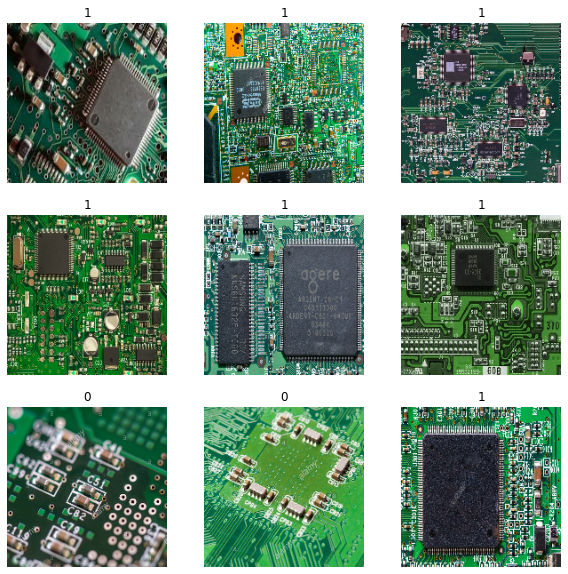

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# The images with label 1 are Negative and they don't posses a silicon chip while the images with label 2 are Positive and have a silicon chip        

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        # ax = plt.subplot(3, 3, i + 1)
        # plt.imshow(augmented_images[0].numpy().astype("uint8"))
        # plt.axis("off")

# get number of data points after augmentation
# TODO
print(type(train_ds.take(1)))

<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>


<Figure size 720x720 with 0 Axes>

In [14]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

#Model initilization and creation

In [15]:
"""
set up model's initialization parameters.
"""
classes = ["si_posive", "si_negative"]
number_of_classes = len(classes)


<IPython.core.display.Javascript object>

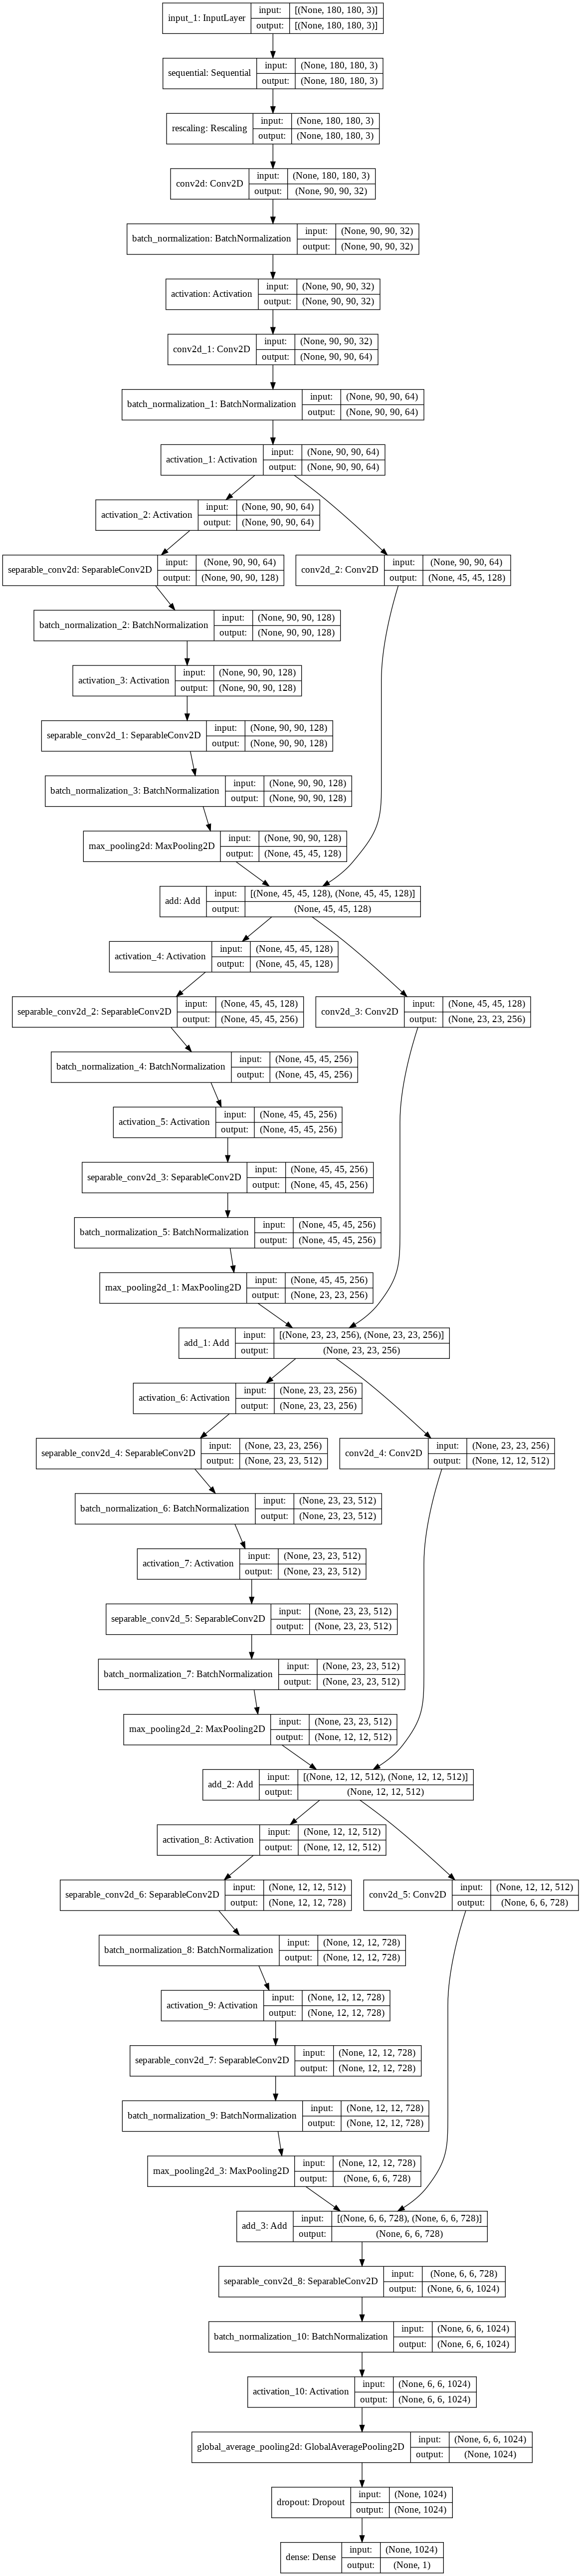

In [16]:
disable_auto_scroll_of_output()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [17]:
disable_auto_scroll_of_output()

epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


<IPython.core.display.Javascript object>

Epoch 1/50
2/2 [==============================] - 41s 4s/step - loss: 0.6531 - accuracy: 0.6271 - val_loss: 0.6935 - val_accuracy: 0.4737
Epoch 2/50
2/2 [==============================] - 1s 426ms/step - loss: 0.6096 - accuracy: 0.7095 - val_loss: 0.6934 - val_accuracy: 0.4737
Epoch 3/50
2/2 [==============================] - 1s 425ms/step - loss: 0.4524 - accuracy: 0.7717 - val_loss: 0.6933 - val_accuracy: 0.4737
Epoch 4/50
2/2 [==============================] - 1s 445ms/step - loss: 0.4703 - accuracy: 0.7977 - val_loss: 0.6934 - val_accuracy: 0.4737
Epoch 5/50
2/2 [==============================] - 1s 422ms/step - loss: 0.3326 - accuracy: 0.8267 - val_loss: 0.6932 - val_accuracy: 0.5263
Epoch 6/50
2/2 [==============================] - 1s 431ms/step - loss: 0.4000 - accuracy: 0.8122 - val_loss: 0.6929 - val_accuracy: 0.5263
Epoch 7/50
2/2 [==============================] - 1s 424ms/step - loss: 0.2064 - accuracy: 0.9104 - val_loss: 0.6928 - val_accuracy: 0.5263
Epoch 8/50
2/2 [======

In [22]:
disable_auto_scroll_of_output()

root = "/content/data"
classes = ["Positive", "Negative"]
conf_matrix = [[0,0],[0,0]]     # [[TP,FP],[FN,TN]]

for _class in classes:
    # generate a list of available images under test
    genIMU = list(getImages(os.path.join(root,_class)))
    print(f"Found {len(genIMU)} images in {_class} class")
    for image in genIMU:
        print(f"Testing {image}, which is silicon-{_class.lower()}")
        # uncomment the line below to display the image under test
        # display(Image(image))
        img = keras.preprocessing.image.load_img(
            image, target_size=image_size
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  
        predictions = model.predict(img_array)
        if predictions[0][0] == 1:
          print("[Prediction] Image is Negative. The Image does not contain a silicon chip.")
          if _class is "Negative": 
            conf_matrix[1][1]+=1
          else: 
            conf_matrix[1][0]+=1
        
        else:
          print("[Prediction] Image is Positive. The Image contains a silicon chip")
          if _class is "Negative": 
            conf_matrix[0][1]+=1
          else: 
            conf_matrix[0][0]+=1

        score = predictions[0]
        print(
            "[Prediction] This image is %.2f percent Negative and %.2f percent Positive.\n"
            % (100 * (1 - score), 100 * score))

<IPython.core.display.Javascript object>

Found 46 images in Positive class
Testing /content/data/Positive/34.jpg, which is silicon-positive
[Prediction] Image is Positive. The Image contains a silicon chip
[Prediction] This image is 62.99 percent Negative and 37.01 percent Positive.

Testing /content/data/Positive/50.jpg, which is silicon-positive
[Prediction] Image is Positive. The Image contains a silicon chip
[Prediction] This image is 62.66 percent Negative and 37.34 percent Positive.

Testing /content/data/Positive/21.jpg, which is silicon-positive
[Prediction] Image is Positive. The Image contains a silicon chip
[Prediction] This image is 62.86 percent Negative and 37.14 percent Positive.

Testing /content/data/Positive/30.jpg, which is silicon-positive
[Prediction] Image is Positive. The Image contains a silicon chip
[Prediction] This image is 63.02 percent Negative and 36.98 percent Positive.

Testing /content/data/Positive/25.jpg, which is silicon-positive
[Prediction] Image is Positive. The Image contains a silicon 

In [19]:
# [[TP,FP],[FN,TN]]

print(f"TP={conf_matrix[0][0]}")
print(f"FP={conf_matrix[0][1]}")
print(f"FN={conf_matrix[1][0]}")
print(f"TN={conf_matrix[1][1]}")

TP=46
FP=50
FN=0
TN=0


In [20]:
# single test -- carrot
root = "/content"
classes = ["rand"]
conf_matrix = [[0,0],[0,0]]     # [[TP,FP],[FN,TN]]

for _class in classes:
    # generate a list of available images under test
    genIMU = list(getImages(os.path.join(root,_class)))
    for image in genIMU:
        print(f"Testing {image}, which is silicon-{_class.lower()}")
        # uncomment the line below to display the image under test
        # display(Image(image))
        img = keras.preprocessing.image.load_img(
            image, target_size=image_size
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  
        predictions = model.predict(img_array)
        if predictions[0][0] == 1:
          print("[Prediction] Image is Negative. The Image does not contain a silicon chip.")
          if _class is "Negative": 
            conf_matrix[1][1]+=1
          else: 
            conf_matrix[1][0]+=1
        
        else:
          print("[Prediction] Image is Positive. The Image contains a silicon chip")
          if _class is "Negative": 
            conf_matrix[0][1]+=1
          else: 
            conf_matrix[0][0]+=1

        score = predictions[0]
        print(
            "[Prediction] This image is %.2f percent Negative and %.2f percent Positive.\n"
            % (100 * (1 - score), 100 * score))

# Object localization

Using OpenCV's selective search class, find proposed objects in a given image based on shape, color.

For more on selective search, read: http://www.huppelen.nl/publications/selectiveSearchDraft.pdf

<IPython.core.display.Javascript object>

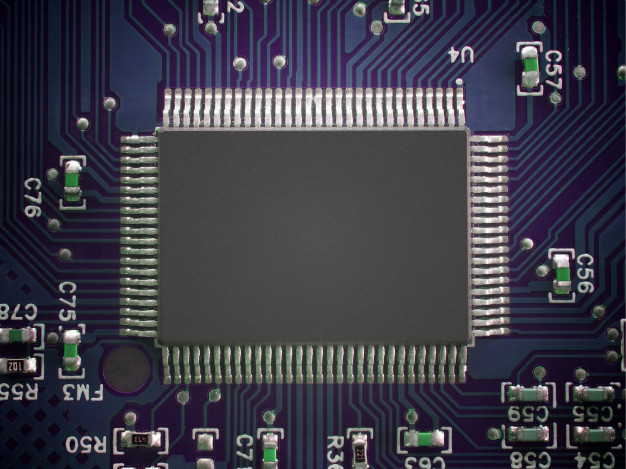

'Image as-is:'

None

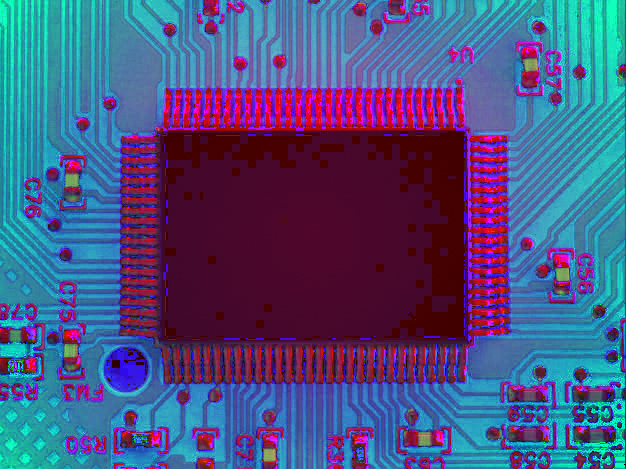

'Image with modified color space'

None

Selective Search took 6.398432731628418 s
Found 4272 proposed objects


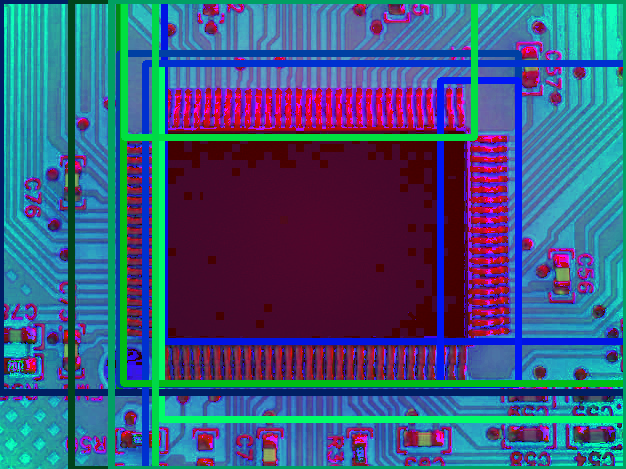

None

In [21]:
disable_auto_scroll_of_output()

from doSelectiveSearch import *

# path = os.path.join("/content","tball.jpeg")
# path = os.path.join("/content","cherry.png")
path = os.path.join("/content","data", "Positive", "18.jpg")
# path = os.path.join("/content","data", "Negative", "6.jpg")

doSelectiveSearch(inputImgPath=path, 
                  fastNotAccurate=True, 
                  showImage=False, 
                  numOfObjectsPerImage=20, 
                  changeColorSpace=True)